# ロジスティック回帰モデル

機械学習の文脈だったりエコノメの文脈だったりで若干導入が違う（[ロジスティック回帰の4通りの表現 - ill-identified diary](https://ill-identified.hatenablog.com/entry/2024/04/26/033151)）

ここではGLM文脈のものにする

## GLMとしての定式化

ロジスティック回帰はGLMの3つの構成要素で記述できる。

### 変量成分

目的変数 $Y_i$ は「成功」（1）か「失敗」（0）の二値をとり、成功確率 $\pi_i$ のベルヌーイ分布に従う：

$$
Y_i \sim \text{Bernoulli}(\pi_i), \quad i = 1, \dots, n
$$

$n_i$ 回中の成功回数 $Y_i$ を扱う場合は二項分布 $Y_i \sim \text{Binomial}(n_i, \pi_i)$ になる。

ベルヌーイ分布は指数型分布族に属する。確率関数を

$$
f(y_i \mid \pi_i) = \pi_i^{y_i} (1 - \pi_i)^{1 - y_i}
= \exp\left( y_i \log\frac{\pi_i}{1 - \pi_i} + \log(1 - \pi_i) \right)
$$

と書けば、自然パラメータが $\eta_i = \log\frac{\pi_i}{1 - \pi_i}$（ロジット）であることがわかる。

### リンク関数

自然パラメータに合わせ、**ロジットリンク**（logit link）を用いる：

$$
g(\pi_i) = \log\frac{\pi_i}{1 - \pi_i} = \text{logit}(\pi_i)
$$

これは正準リンク関数（canonical link function）であり、理論的に好ましい性質を持つ。

### 系統的成分

線形予測子 $\eta_i$ は

$$
\eta_i = \mathbf{x}_i^\top \boldsymbol{\beta} = \beta_0 + \beta_1 x_{i1} + \cdots + \beta_p x_{ip}
$$

### 3つをまとめると

$$
\text{logit}(\pi_i) = \log\frac{\pi_i}{1 - \pi_i} = \mathbf{x}_i^\top \boldsymbol{\beta}
$$

逆リンク関数（ロジスティック関数）で $\pi_i$ を表すと

$$
\pi_i = \frac{1}{1 + \exp(-\mathbf{x}_i^\top \boldsymbol{\beta})} = \text{logistic}(\mathbf{x}_i^\top \boldsymbol{\beta})
$$

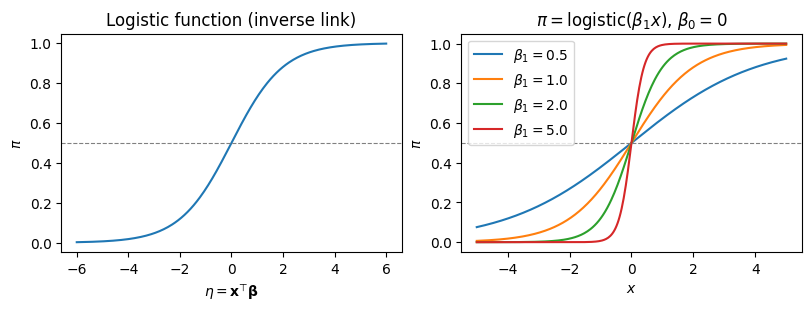

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# ロジスティック関数の可視化
eta = np.linspace(-6, 6, 300)
pi = 1 / (1 + np.exp(-eta))

fig, axes = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True)

axes[0].plot(eta, pi)
axes[0].axhline(0.5, color="gray", linestyle="--", linewidth=0.8)
axes[0].set(xlabel=r"$\eta = \mathbf{x}^\top \mathbf{\beta}$",
            ylabel=r"$\pi$",
            title="Logistic function (inverse link)")

# 異なる β_1 によるロジスティック曲線
x = np.linspace(-5, 5, 300)
for b1 in [0.5, 1.0, 2.0, 5.0]:
    axes[1].plot(x, 1 / (1 + np.exp(-b1 * x)), label=rf"$\beta_1 = {b1}$")
axes[1].axhline(0.5, color="gray", linestyle="--", linewidth=0.8)
axes[1].set(xlabel=r"$x$", ylabel=r"$\pi$",
            title=r"$\pi = \mathrm{logistic}(\beta_1 x)$, $\beta_0=0$")
axes[1].legend()
plt.show()

## 係数の解釈：オッズ比

ロジスティック回帰の係数はオッズ比（odds ratio）として解釈できる。

### オッズ

ある事象の成功確率を $\pi$ とするとき、**オッズ**（odds）は

$$
\text{odds} = \frac{\pi}{1 - \pi}
$$

で定義される。例えば $\pi = 0.8$ なら $\text{odds} = 4$（成功4回に対し失敗1回）。

### オッズ比

ロジスティック回帰モデルにおいて、説明変数 $x_j$ が1単位増加したときのオッズの変化率を考える。

$x_j$ の値が $x_j$ と $x_j + 1$ の場合のオッズの比は

$$
\frac{\text{odds}(x_j + 1)}{\text{odds}(x_j)}
= \frac{\exp(\cdots + \beta_j(x_j + 1) + \cdots)}{\exp(\cdots + \beta_j x_j + \cdots)}
= \exp(\beta_j)
$$

すなわち $\exp(\beta_j)$ は、他の変数を一定に保ったとき $x_j$ が1単位増加した場合のオッズの変化倍率である。

- $\beta_j > 0 \Leftrightarrow \exp(\beta_j) > 1$：$x_j$ が増えると成功確率が上がる
- $\beta_j = 0 \Leftrightarrow \exp(\beta_j) = 1$：$x_j$ は成功確率に影響しない
- $\beta_j < 0 \Leftrightarrow \exp(\beta_j) < 1$：$x_j$ が増えると成功確率が下がる

## 最尤推定

### 対数尤度関数

$n$ 個の独立な観測 $(y_i, \mathbf{x}_i)$ に対する対数尤度は

$$
\ell(\boldsymbol{\beta}) = \sum_{i=1}^{n} \left[ y_i \log \pi_i + (1 - y_i) \log(1 - \pi_i) \right]
$$

$\pi_i = \text{logistic}(\mathbf{x}_i^\top \boldsymbol{\beta})$ を代入すると

$$
\ell(\boldsymbol{\beta}) = \sum_{i=1}^{n} \left[ y_i\, \mathbf{x}_i^\top \boldsymbol{\beta} - \log\left(1 + \exp(\mathbf{x}_i^\top \boldsymbol{\beta})\right) \right]
$$

### スコア関数

対数尤度の $\boldsymbol{\beta}$ に関する偏微分（スコア関数）は

$$
\frac{\partial \ell}{\partial \boldsymbol{\beta}} = \sum_{i=1}^{n} (y_i - \pi_i)\, \mathbf{x}_i = \mathbf{X}^\top (\mathbf{y} - \boldsymbol{\pi})
$$

スコア関数を $\mathbf{0}$ と置いた方程式は $\boldsymbol{\beta}$ について解析的に解けないため、反復法で数値的に解く。

### Fisher情報行列

観測Fisher情報行列は

$$
\mathbf{F}(\boldsymbol{\beta}) = -\frac{\partial^2 \ell}{\partial \boldsymbol{\beta}\, \partial \boldsymbol{\beta}^\top} = \mathbf{X}^\top \mathbf{W} \mathbf{X}
$$

ここで $\mathbf{W} = \text{diag}(\pi_1(1-\pi_1), \dots, \pi_n(1-\pi_n))$ は重み行列である。

### IRLS（反復再重み付け最小二乗法）

GLMの枠組みでは、Fisherスコアリング法が使われる。これはニュートン・ラフソン法と等価であり、IRLS（Iteratively Reweighted Least Squares）として実装される。

更新式は

$$
\boldsymbol{\beta}^{(t+1)} = (\mathbf{X}^\top \mathbf{W}^{(t)} \mathbf{X})^{-1}\, \mathbf{X}^\top \mathbf{W}^{(t)} \mathbf{z}^{(t)}
$$

ここで $\mathbf{z}^{(t)}$ は作業従属変数（working dependent variable）で

$$
z_i^{(t)} = \eta_i^{(t)} + \frac{y_i - \pi_i^{(t)}}{\pi_i^{(t)}(1 - \pi_i^{(t)})}
$$

すなわち、各反復で重み $\mathbf{W}$ を更新しながら重み付き最小二乗法を繰り返すことでMLEを得る。

### IRLSのスクラッチ実装

In [11]:
def logistic(eta: np.ndarray) -> np.ndarray:
    """ロジスティック関数（数値安定版）"""
    return np.where(eta >= 0,
                    1 / (1 + np.exp(-eta)),
                    np.exp(eta) / (1 + np.exp(eta)))


def logistic_regression_irls(
    X: np.ndarray,
    y: np.ndarray,
    max_iter: int = 25,
    tol: float = 1e-8,
) -> dict:
    """
    IRLSによるロジスティック回帰の最尤推定

    Parameters
    ----------
    X : np.ndarray, shape (n, p)
        計画行列（切片列を含む）
    y : np.ndarray, shape (n,)
        目的変数（0/1）
    max_iter : int
        最大反復回数
    tol : float
        収束判定の閾値

    Returns
    -------
    dict
        beta, se, log_likelihood, n_iter
    """
    n, p = X.shape
    beta = np.zeros(p)

    for iteration in range(max_iter):
        eta = X @ beta
        pi = logistic(eta)

        # 重み行列の対角要素
        w = pi * (1 - pi)
        w = np.clip(w, 1e-10, None)  # 数値安定性

        # 作業従属変数
        z = eta + (y - pi) / w

        # 重み付き最小二乗法
        W = np.diag(w)
        XtWX = X.T @ W @ X
        XtWz = X.T @ W @ z

        beta_new = np.linalg.solve(XtWX, XtWz)

        # 収束判定
        if np.max(np.abs(beta_new - beta)) < tol:
            beta = beta_new
            break
        beta = beta_new

    # 最終結果
    eta = X @ beta
    pi = logistic(eta)
    log_lik = np.sum(y * np.log(pi + 1e-15) + (1 - y) * np.log(1 - pi + 1e-15))

    # 標準誤差
    w = pi * (1 - pi)
    XtWX = X.T @ np.diag(w) @ X
    cov = np.linalg.inv(XtWX)
    se = np.sqrt(np.diag(cov))

    return {
        "beta": beta,
        "se": se,
        "log_likelihood": log_lik,
        "n_iter": iteration + 1,
        "cov": cov,
    }

### シミュレーションデータでの検証

スクラッチ実装を `statsmodels` の結果と比較する。

In [12]:
import pandas as pd
import statsmodels.api as sm

# データ生成
rng = np.random.default_rng(42)
n = 500
x1 = rng.normal(0, 1, n)
x2 = rng.normal(0, 1, n)
beta_true = np.array([-0.5, 1.2, -0.8])  # beta_0, beta_1, beta_2
X = np.column_stack([np.ones(n), x1, x2])
eta = X @ beta_true
pi_true = logistic(eta)
y = rng.binomial(1, pi_true)

print(f"サンプルサイズ: {n}")
print(f"真の係数: β₀={beta_true[0]}, β₁={beta_true[1]}, β₂={beta_true[2]}")
print(f"y=1 の割合: {y.mean():.3f}")

サンプルサイズ: 500
真の係数: β₀=-0.5, β₁=1.2, β₂=-0.8
y=1 の割合: 0.428


In [13]:
# スクラッチ実装
result_irls = logistic_regression_irls(X, y)

# statsmodels
model_sm = sm.GLM(y, X, family=sm.families.Binomial())
result_sm = model_sm.fit()

# 比較
comparison = pd.DataFrame({
    "真の値": beta_true,
    "IRLS (自前)": result_irls["beta"],
    "statsmodels": result_sm.params,
    "SE (自前)": result_irls["se"],
    "SE (statsmodels)": result_sm.bse,
}, index=["β₀", "β₁", "β₂"])

print(f"IRLS 反復回数: {result_irls['n_iter']}")
print(f"対数尤度 (自前): {result_irls['log_likelihood']:.4f}")
print(f"対数尤度 (statsmodels): {result_sm.llf:.4f}")
print()
comparison

IRLS 反復回数: 6
対数尤度 (自前): -261.2875
対数尤度 (statsmodels): -261.2875



,真の値,IRLS (自前),statsmodels,SE (自前),SE (statsmodels)
β₀,-0.5,-0.427388,-0.427388,0.108908,0.108908
β₁,1.2,1.219814,1.219814,0.139285,0.139285
β₂,-0.8,-0.905850,-0.905850,0.123665,0.123665


## 仮説検定

### Wald検定

個々の係数について $H_0: \beta_j = 0$ を検定する。Wald統計量は

$$
z_j = \frac{\hat{\beta}_j}{\text{SE}(\hat{\beta}_j)}
$$

で、漸近的に標準正規分布に従う。`statsmodels` の summary に表示される $z$ 値と $P>|z|$ がこれに対応する。

### 尤度比検定

帰無モデル（null model: 切片のみ）と完全モデルを比較する。尤度比統計量は

$$
G^2 = -2 \left[ \ell(\hat{\boldsymbol{\beta}}_0) - \ell(\hat{\boldsymbol{\beta}}) \right]
$$

で漸近的に自由度 $p$ の $\chi^2$ 分布に従う。

### 逸脱度（deviance）

GLMでは逸脱度が適合度の指標として用いられる。ロジスティック回帰の逸脱度は

$$
D = -2\, \ell(\hat{\boldsymbol{\beta}}) = -2 \sum_{i=1}^{n} \left[ y_i \log \hat{\pi}_i + (1 - y_i) \log(1 - \hat{\pi}_i) \right]
$$

逸脱度はモデル比較やモデル選択に使われる。AICは $\text{AIC} = D + 2p$ で計算できる。

In [14]:
print(result_sm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  500
Model:                            GLM   Df Residuals:                      497
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -261.29
Date:                Fri, 13 Feb 2026   Deviance:                       522.57
Time:                        23:57:51   Pearson chi2:                     508.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2741
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4274      0.109     -3.924      0.0

In [15]:
# オッズ比と95%信頼区間
from scipy import stats

beta_hat = result_sm.params
se = result_sm.bse
z_crit = stats.norm.ppf(0.975)

odds_ratio_df = pd.DataFrame({
    "β": beta_hat,
    "OR (exp(β))": np.exp(beta_hat),
    "OR 95% CI lower": np.exp(beta_hat - z_crit * se),
    "OR 95% CI upper": np.exp(beta_hat + z_crit * se),
    "p-value": result_sm.pvalues,
}, index=["intercept", "x₁", "x₂"])

odds_ratio_df

,β,OR (exp(β)),OR 95% CI lower,OR 95% CI upper,p-value
intercept,-0.427388,0.652210,0.526848,0.807402,8.697494e-05
x₁,1.219814,3.386559,2.577500,4.449576,1.993489e-18
x₂,-0.905850,0.404198,0.317198,0.515060,2.388104e-13


## 実データでの例

Titanic データセットを用いて、乗客の生存を予測するロジスティック回帰を行う。

In [16]:
# statsmodels 組み込みの Titanic データ
titanic = sm.datasets.get_rdataset("Titanic", "datasets").data

# 集計データを個票データに展開
rows = []
for _, row in titanic.iterrows():
    for _ in range(int(row["Freq"])):
        rows.append({
            "Class": row["Class"],
            "Sex": row["Sex"],
            "Age": row["Age"],
            "Survived": 1 if row["Survived"] == "Yes" else 0,
        })
df = pd.DataFrame(rows)
print(f"サンプルサイズ: {len(df)}")
print(f"生存率: {df['Survived'].mean():.3f}")
print()
df.groupby(["Class", "Sex"])["Survived"].mean().unstack()

サンプルサイズ: 2201
生存率: 0.323



Sex,Female,Male
Class,,
1st,0.972414,0.344444
2nd,0.877358,0.139665
3rd,0.459184,0.172549
Crew,0.869565,0.222738


In [17]:
from statsmodels.formula.api import logit

# ロジスティック回帰モデルの推定
model_titanic = logit("Survived ~ C(Class) + C(Sex) + C(Age)", data=df).fit(disp=0)
print(model_titanic.summary())

                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                 2201
Model:                          Logit   Df Residuals:                     2195
Method:                           MLE   Df Model:                            5
Date:                Fri, 13 Feb 2026   Pseudo R-squ.:                  0.2020
Time:                        23:58:44   Log-Likelihood:                -1105.0
converged:                       True   LL-Null:                       -1384.7
Covariance Type:            nonrobust   LLR p-value:                1.195e-118
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.0438      0.168     12.171      0.000       1.715       2.373
C(Class)[T.2nd]     -1.0181      0.196     -5.194      0.000      -1.402      -0.634
C(Class)[T.3rd]     -1.7778 

In [18]:
# オッズ比の表示
or_df = pd.DataFrame({
    "β": model_titanic.params,
    "OR": np.exp(model_titanic.params),
    "OR 95%CI lower": np.exp(model_titanic.conf_int()[0]),
    "OR 95%CI upper": np.exp(model_titanic.conf_int()[1]),
    "p-value": model_titanic.pvalues,
})
or_df

,β,OR,OR 95%CI lower,OR 95%CI upper,p-value
Intercept,2.043837,7.720178,5.555016,10.729248,4.447236e-34
C(Class)[T.2nd],-1.018095,0.361283,0.246044,0.530494,2.053519e-07
C(Class)[T.3rd],-1.777762,0.169016,0.120751,0.236573,3.694113e-25
C(Class)[T.Crew],-0.857676,0.424147,0.311594,0.577355,5.004844e-08
C(Sex)[T.Male],-2.420060,0.088916,0.067525,0.117084,1.434209e-66
C(Age)[T.Child],1.061542,2.890826,1.791872,4.663769,1.360598e-05


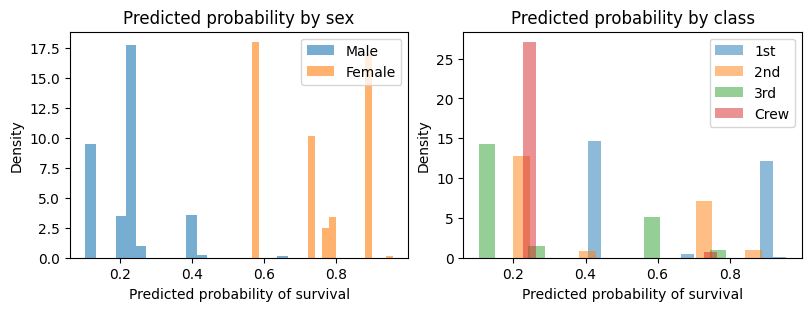

In [23]:
# 予測確率の可視化
df["pred_prob"] = model_titanic.predict(df)

fig, axes = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True)

# 性別ごとの予測確率分布
for sex in ["Male", "Female"]:
    mask = df["Sex"] == sex
    axes[0].hist(df.loc[mask, "pred_prob"], bins=20, alpha=0.6, label=sex, density=True)
axes[0].set(xlabel="Predicted probability of survival", ylabel="Density",
            title="Predicted probability by sex")
axes[0].legend()

# 客室クラスごとの予測確率分布
for cls in ["1st", "2nd", "3rd", "Crew"]:
    mask = df["Class"] == cls
    axes[1].hist(df.loc[mask, "pred_prob"], bins=15, alpha=0.5, label=cls, density=True)
axes[1].set(xlabel="Predicted probability of survival", ylabel="Density",
            title="Predicted probability by class")
axes[1].legend()

plt.show()

## 他のリンク関数

ロジスティック回帰ではロジットリンクが標準だが、二項分布のGLMに対して別のリンク関数を用いることもできる。

| リンク関数 | $g(\pi)$ | 逆リンク $g^{-1}(\eta)$ | 特徴 |
|-----------|----------|-------------------|------|
| ロジット (logit) | $\log\frac{\pi}{1-\pi}$ | $\frac{1}{1+e^{-\eta}}$ | 正準リンク。オッズ比として解釈可能 |
| プロビット (probit) | $\Phi^{-1}(\pi)$ | $\Phi(\eta)$ | 潜在変数モデルとの対応。計量経済学で好まれる |
| 補対数対数 (cloglog) | $\log(-\log(1-\pi))$ | $1 - e^{-e^{\eta}}$ | 非対称。まれな事象の分析に適する |

ここで $\Phi$ は標準正規分布の累積分布関数。

実用上、ロジットとプロビットの推定結果はほとんどの場合で非常に近い（プロビットの係数 $\approx$ ロジットの係数 $\times 0.6$）。

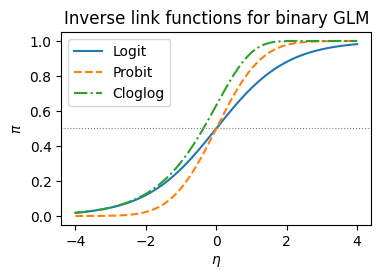

In [22]:
# 3つのリンク関数の比較
eta = np.linspace(-4, 4, 300)
logistic_curve = 1 / (1 + np.exp(-eta))
probit_curve = stats.norm.cdf(eta)
cloglog_curve = 1 - np.exp(-np.exp(eta))

fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(eta, logistic_curve, label="Logit")
ax.plot(eta, probit_curve, label="Probit", linestyle="--")
ax.plot(eta, cloglog_curve, label="Cloglog", linestyle="-.")
ax.axhline(0.5, color="gray", linestyle=":", linewidth=0.8)
ax.set(xlabel=r"$\eta$", ylabel=r"$\pi$",
       title="Inverse link functions for binary GLM")
ax.legend()
plt.show()

## 完全分離と準完全分離

ロジスティック回帰の推定で注意すべき問題として**完全分離**（complete separation）がある。

ある説明変数（またはその線形結合）によって $y = 0$ と $y = 1$ が完全に分離できる場合、MLEが存在しない（$\hat{\beta}_j \to \pm\infty$）。これは対数尤度が有限の最大値を持たず、上界に漸近するためである。

- **完全分離**: $y=0$ と $y=1$ を完全に分離する超平面が存在する。MLEが存在しない
- **準完全分離**（quasi-complete separation）: 分離境界上にデータ点が乗る。一部のMLEが存在しない

実務上の対処法として：

1. サンプルサイズを増やす
2. Firth の補正（penalized likelihood）を用いる
3. ベイズ推定で事前分布による正則化を行う

`statsmodels` では収束しない場合や標準誤差が非常に大きい場合に警告が出る。

## 参考文献

:::{card}

Agresti, A. (2013). *Categorical Data Analysis* (3rd ed.). Wiley.

カテゴリカルデータ分析の標準的な教科書。ロジスティック回帰の理論と応用が詳しい

:::

:::{card}

McCullagh, P., & Nelder, J. A. (1989). *Generalized Linear Models* (2nd ed.). Chapman & Hall.

GLMの原典

:::

:::{card}

Hosmer, D. W., Lemeshow, S., & Sturdivant, R. X. (2013). *Applied Logistic Regression* (3rd ed.). Wiley.

ロジスティック回帰に特化した応用的教科書

:::